In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import fetch_openml
import joblib

# Part 1 California housing data
From https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset :

This dataset was obtained from the StatLib repository. https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

We looked at this data when we talked about linear regression. Your task is to build a model to predict house price. 

1. Use GridSearchCV or RandomizedSearchCV to tune a single decision tree model. Use scoring = 'neg_root_mean_squared_error'.
2. Use GridSearchCV or RandomizedSearchCV to tune a random forest model.
3. Use GridSearchCV or RandomizedSearchCV to tune an adaboost model with decision trees as the base learners.
4. For each search, report r squared on the training and test sets for the best model. Also, compute predictions using the best model from each search and compute RMSE. Which type of model had the best predicitons? 

In [4]:
houses = pd.read_csv('housing.csv')
houses.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Price'],
      dtype='object')

In [14]:
X = houses[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude']]
y = houses['Price'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=440)
X_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
10347,7.1497,21.0,6.755245,0.930070,860.0,3.006993,33.61,-117.66
9297,6.5253,24.0,7.281250,1.006250,911.0,2.846875,38.03,-122.57
10277,5.8243,13.0,5.838420,1.046679,1546.0,2.775583,33.89,-117.81
18010,5.9658,17.0,5.873077,1.026923,775.0,2.980769,37.27,-121.99
5733,6.8317,31.0,6.438515,1.022042,2465.0,2.859629,34.16,-118.20
...,...,...,...,...,...,...,...,...
367,5.0000,41.0,6.790123,1.027778,1476.0,2.277778,37.74,-122.13
5181,1.6887,44.0,4.465587,1.072874,760.0,3.076923,33.94,-118.26
15890,2.2167,40.0,6.101124,1.134831,259.0,2.910112,37.73,-122.38
19478,3.1286,19.0,5.236074,1.042440,799.0,2.119363,37.66,-120.97


In [28]:
#1.1
dt = DecisionTreeRegressor(random_state=440)
dt_params = {"max_depth": [ 17, 18, 19],
              "min_samples_split": [2, 5, 10, 20],
              'min_samples_leaf': [2, 5, 10, 20]}
dt_search = GridSearchCV(dt, dt_params, cv=5, scoring='neg_root_mean_squared_error')
dt_search.fit(X_train, y_train)
dt_best = dt_search.best_estimator_

print("Basic Decision Tree best params:", dt_search.best_params_)
print("Basic Decision Tree train:", dt_best.score(X_train, y_train))
print("Basic Decision Tree test:", dt_best.score(X_test, y_test))

Basic Decision Tree best params: {'max_depth': 18, 'min_samples_leaf': 20, 'min_samples_split': 2}
Basic Decision Tree train: 0.8088229003887568
Basic Decision Tree test: 0.733057927483054


In [30]:
#1.2
rf = RandomForestRegressor(random_state=440)
rf_params = {"max_depth": [2,3,5, 7, 10, 12, None],
              "min_samples_split": [2, 5, 10, 20],
              'min_samples_leaf': [2, 5, 10, 20],
              'n_estimators': [50, 100, 200]}
rf_search = RandomizedSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_iter=50)

#rf_search = GridSearchCV(rf, rf_params, cv=5)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_


print("Random Forest best params:", rf_search.best_params_)
print("Random Forest train:", rf_best.score(X_train, y_train))
print("Random Forest test:", rf_best.score(X_test, y_test))

Random Forest best params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None}
Random Forest train: 0.9318440309009991
Random Forest test: 0.8019733442214849


In [31]:
#1.3
ab = AdaBoostRegressor(random_state=440)
ab_params = {'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1, 1.5],
                'estimator': [
                DecisionTreeRegressor(max_depth=1),
                DecisionTreeRegressor(max_depth=2),
                DecisionTreeRegressor(max_depth=3),
                DecisionTreeRegressor(max_depth=4),
                DecisionTreeRegressor(max_depth=5),
                DecisionTreeRegressor(max_depth=10)
            ]
}

ab_search = GridSearchCV(ab, ab_params, cv=5, scoring='neg_root_mean_squared_error')
ab_search.fit(X_train, y_train)
ab_best = ab_search.best_estimator_

print("AdaBoost best params:", ab_search.best_params_)
print("AdaBoost train:", ab_best.score(X_train, y_train))
print("AdaBoost test:", ab_best.score(X_test, y_test))


AdaBoost best params: {'estimator': DecisionTreeRegressor(max_depth=10), 'learning_rate': 1.5, 'n_estimators': 200}
AdaBoost train: 0.9276706454413366
AdaBoost test: 0.8107893658525471


In [32]:
# 1.4

y_train_pred_dt = dt_best.predict(X_train)
y_test_pred_dt = dt_best.predict(X_test)

dt_train_r2 = dt_best.score(X_train, y_train)
dt_test_r2 = dt_best.score(X_test, y_test)
dt_train_rmse = np.sqrt(mse(y_train, y_train_pred_dt))
dt_test_rmse = np.sqrt(mse(y_test, y_test_pred_dt))

print("Decision Tree Results:")
print("Train R-squared:", round(dt_train_r2, 4))
print("Test R-squared:", round(dt_test_r2, 4))
print("Train RMSE:", round(dt_train_rmse, 4))
print("Test RMSE:", round(dt_test_rmse, 4))


y_train_pred_rf = rf_best.predict(X_train)
y_test_pred_rf = rf_best.predict(X_test)

rf_train_r2 = rf_best.score(X_train, y_train)
rf_test_r2 = rf_best.score(X_test, y_test)
rf_train_rmse = np.sqrt(mse(y_train, y_train_pred_rf))
rf_test_rmse = np.sqrt(mse(y_test, y_test_pred_rf))

print("\nRandom Forest Results:")
print("Train R-squared:", round(rf_train_r2, 4))
print("Test R-squared:", round(rf_test_r2, 4))
print("Train RMSE:", round(rf_train_rmse, 4))
print("Test RMSE:", round(rf_test_rmse, 4))


y_train_pred_ab = ab_best.predict(X_train)
y_test_pred_ab = ab_best.predict(X_test)

ab_train_r2 = ab_best.score(X_train, y_train)
ab_test_r2 = ab_best.score(X_test, y_test)
ab_train_rmse = np.sqrt(mse(y_train, y_train_pred_ab))
ab_test_rmse = np.sqrt(mse(y_test, y_test_pred_ab))

print("\nAdaBoost Results:")
print("Train R-squared:", round(ab_train_r2, 4))
print("Test R-squared:", round(ab_test_r2, 4))
print("Train RMSE:", round(ab_train_rmse, 4))
print("Test RMSE:", round(ab_test_rmse, 4))




Decision Tree Results:
Train R-squared: 0.8088
Test R-squared: 0.7331
Train RMSE: 0.5038
Test RMSE: 0.598

Random Forest Results:
Train R-squared: 0.9318
Test R-squared: 0.802
Train RMSE: 0.3008
Test RMSE: 0.515

AdaBoost Results:
Train R-squared: 0.9277
Test R-squared: 0.8108
Train RMSE: 0.3099
Test RMSE: 0.5034


Using the above results, Adaboost had the highest R-squared and the lowest RMSE although the other two models were not far behind, within a percent or two for each stat. 

# Part 2 MNIST handwritten digits
Your task is to build a model to classify handwritten digits.
Use GridSearchCV or RandomizedSearchCV to tune a single decision tree model. Use scoring = 'neg_root_mean_squared_error'.
Use GridSearchCV or RandomizedSearchCV to tune a random forest model. I used a randomized search with 
Use GridSearchCV or RandomizedSearchCV to tune an adaboost model with decision trees as the base learners.
For each search, report accuracy score and show a confusion matrix.

In [45]:
mnist = fetch_openml('mnist_784', return_X_y=False)
X, y = mnist['data'], mnist['target']
y = y.astype(int)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=290, stratify=y
)

In [47]:
dt = DecisionTreeClassifier(random_state=440)
dt_params = {"max_depth": [ 16, 17, 19,  20],
              "min_samples_split": [2, 5, 10, 20],
              'min_samples_leaf': [2, 5, 10, 20]}
dt_search = RandomizedSearchCV(dt, dt_params, cv=5, scoring='neg_root_mean_squared_error', n_iter=50)
dt_search.fit(X_train, y_train)
dt_best = dt_search.best_estimator_

print("Basic Decision Tree best params:", dt_search.best_params_)
print("Basic Decision Tree train:", dt_best.score(X_train, y_train))
print("Basic Decision Tree test:", dt_best.score(X_test, y_test))

Basic Decision Tree best params: {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 17}
Basic Decision Tree train: 0.9447142857142857
Basic Decision Tree test: 0.8722380952380953


In [48]:
rf = RandomForestClassifier(random_state=440)
rf_params = {"max_depth": [2, 5, 7, 10, 15],
              "min_samples_split": [2, 5, 10, 20],
              'n_estimators': [50, 100, 200]}
rf_search = RandomizedSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_iter=10)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_


print("Random Forest best params:", rf_search.best_params_)
print("Random Forest train:", rf_best.score(X_train, y_train))
print("Random Forest test:", rf_best.score(X_test, y_test))

Random Forest best params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 15}
Random Forest train: 0.9978367346938776
Random Forest test: 0.9642380952380952


In [49]:
ab = AdaBoostClassifier(random_state=440)
ab_params = {'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1, 1.5],
                'estimator': [
                DecisionTreeClassifier(max_depth=1),
                DecisionTreeClassifier(max_depth=2),
                DecisionTreeClassifier(max_depth=3),
                DecisionTreeClassifier(max_depth=4),
                DecisionTreeClassifier(max_depth=5),
                DecisionTreeClassifier(max_depth=10)
            ]
}

ab_search = RandomizedSearchCV(ab, ab_params, cv=5, scoring='neg_root_mean_squared_error', n_iter=5)
ab_search.fit(X_train, y_train)
ab_best = ab_search.best_estimator_

print("AdaBoost best params:", ab_search.best_params_)
print("AdaBoost train:", ab_best.score(X_train, y_train))
print("AdaBoost test:", ab_best.score(X_test, y_test))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

AdaBoost best params: {'n_estimators': 100, 'learning_rate': 1.5, 'estimator': DecisionTreeClassifier(max_depth=10)}
AdaBoost train: 0.9986326530612245
AdaBoost test: 0.9573809523809523


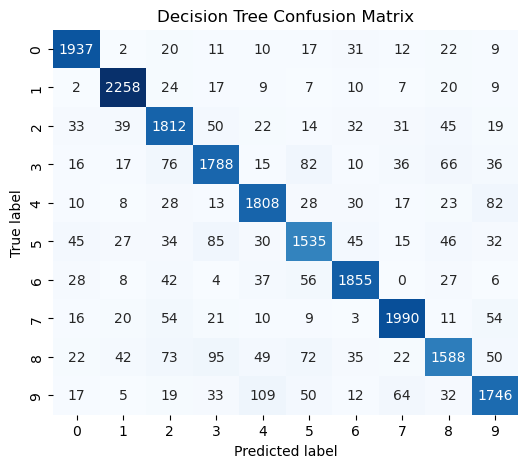

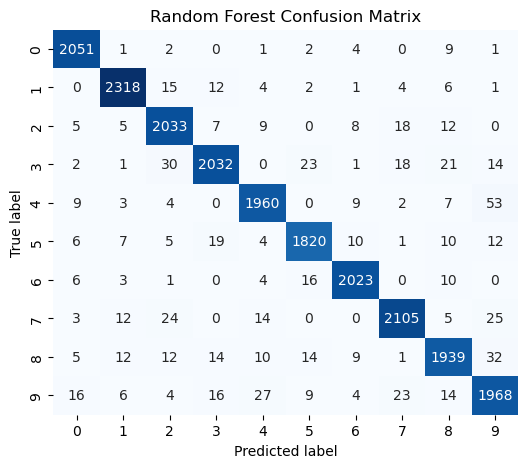

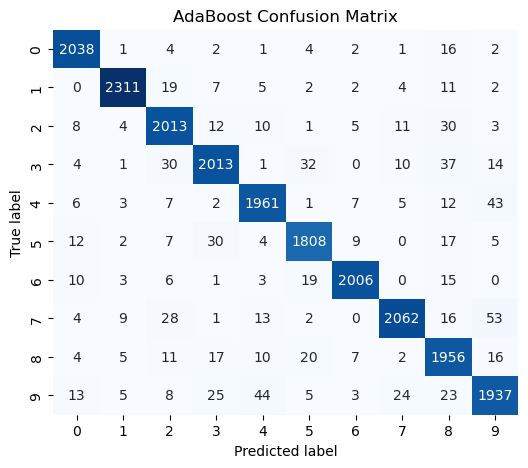

In [51]:
models = [
    ('Decision Tree', dt_best),
    ('Random Forest', rf_best),
    ('AdaBoost', ab_best)
]

for name, model in models:
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False
    )
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
